In [1]:
!pip install scikit-learn
!pip install auquan_toolbox --no-deps
!pip install tensorboardX
!pip install beautifulsoup4
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auquan-toolbox 2.1.92 requires bs4, which is not installed.
auquan-toolbox 2.1.92 requires sklearn, which is not installed.


In [2]:
import scipy
import sklearn
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [3]:
from backtester.dataSource.csv_data_source import CsvDataSource

In [4]:
# ffs
if not hasattr(pd.Series, "iteritems"):
    pd.Series.iteritems = pd.Series.items

In [5]:
# Load the data
cachedFolderName = '/data/'
dataSetId = 'trainingData1'
startDate = '2017/01/06'
endDate = '2017/02/09'
instrumentIds = ['MQK']
downloadUrl = 'https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data'

ds = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             startDateStr=startDate,
                             endDateStr=endDate,
                             liveUpdates=False,
                             pad=True)


https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data/trainingData1/stock_list.txt
Processing data for stock: MQK


In [6]:
#Loading our data
def loadData(ds, id):
    data = ds._bookDataByInstrument[id].getBookData()

    data['Stock Price'] =  (data['stockTopBidPrice'] +\
                           data['stockTopAskPrice']) / 2.0
    data['Future Price'] = (data['futureTopBidPrice'] +\
                           data['futureTopAskPrice']) / 2.0
    data['Y(Target)'] = data['basis'].shift(-5)
    del data['benchmark_score']
    del data['FairValue']
    return data

data = loadData(ds,instrumentIds[0])

In [7]:
print(data.head(6))

                     stockVWAP  futureVWAP  basis  stockTopBidVol  \
2017-01-06 09:17:00    517.773     512.492  5.425            79.0   
2017-01-06 09:18:00    515.300     510.682  4.425            40.0   
2017-01-06 09:19:00    516.225     511.342  4.950            81.0   
2017-01-06 09:20:00    519.792     513.959  5.650           179.0   
2017-01-06 09:21:00    520.270     513.819  6.400            68.0   
2017-01-06 09:22:00    524.792     519.118  5.625          2299.0   

                     stockTopAskVol  stockTopBidPrice  stockTopAskPrice  \
2017-01-06 09:17:00            79.0            518.00            518.30   
2017-01-06 09:18:00            10.0            515.05            515.30   
2017-01-06 09:19:00          1496.0            516.20            516.45   
2017-01-06 09:20:00          1940.0            519.65            519.95   
2017-01-06 09:21:00            93.0            520.45            520.60   
2017-01-06 09:22:00          4924.0            524.60            5

In [8]:
# Training Data
dataSetId =  'trainingData1'
ds_training = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)

training_data = loadData(ds_training, instrumentIds[0])

# Validation Data
dataSetId =  'trainingData2'
ds_validation = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)
validation_data = loadData(ds_validation, instrumentIds[0])

# Test Data
dataSetId =  'trainingData3'
ds_test = CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = 'datetime',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             liveUpdates=False,
                             pad=True)
out_of_sample_test_data = loadData(ds_test, instrumentIds[0])

Processing data for stock: MQK
https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data/trainingData2/stock_list.txt
Processing data for stock: MQK
https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data/trainingData3/stock_list.txt
Processing data for stock: MQK


In [9]:
def prepareData(data, period):
    data['Y(Target)'] = data['basis'].rolling(period).mean().shift(-period)
    if 'FairValue' in data.columns:
        del data['FairValue']
    data.dropna(inplace=True)

period = 5
prepareData(training_data, period)
prepareData(validation_data, period)
prepareData(out_of_sample_test_data, period)

In [10]:
def difference(dataDf, period):
    return dataDf.sub(dataDf.shift(period), fill_value=0)

def ewm(dataDf, halflife):
    return dataDf.ewm(halflife=halflife,ignore_na=False,min_periods=0,adjust=True).mean()

def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi

In [11]:
def create_features_again(data):
    basis_X = pd.DataFrame(index = data.index, columns =  [])

    basis_X['mom10'] = difference(data['basis'],11)

    basis_X['emabasis2'] = ewm(data['basis'],2)
    basis_X['emabasis5'] = ewm(data['basis'],5)
    basis_X['emabasis10'] = ewm(data['basis'],10)

    basis_X['basis'] = data['basis']

    basis_X['totalaskvolratio'] = (data['stockTotalAskVol']-data['futureTotalAskVol'])/100000
    basis_X['totalbidvolratio'] = (data['stockTotalBidVol']-data['futureTotalBidVol'])/100000

    basis_X = basis_X.fillna(0)

    basis_y = data['Y(Target)']
    basis_y.dropna(inplace=True)

    print("Any null data in y: %s, X: %s"%(basis_y.isnull().values.any(), basis_X.isnull().values.any()))
    print("Length y: %s, X: %s"%(len(basis_y.index), len(basis_X.index)))

    return basis_X, basis_y

In [12]:
basis_X_test, basis_y_test = create_features_again(validation_data)
basis_X_train, basis_y_train = create_features_again(training_data)

Any null data in y: False, X: False
Length y: 6499, X: 6499
Any null data in y: False, X: False
Length y: 8737, X: 8737


### Extra Trees ( Bagging ensemble model)

Mean squared error: 0.02
Variance score: 0.95


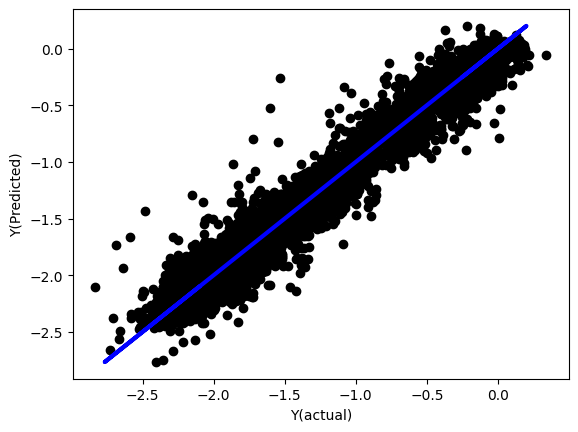

In [13]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

model=ensemble.ExtraTreesRegressor()
model.fit(basis_X_train, basis_y_train)
basis_y_pred = model.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_trees = basis_y_pred.copy()

In [14]:
import pickle
filename = 'MQKmodel.pkl'

with open(filename, 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
!pip install -U auquan_toolbox

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [16]:
from backtester.trading_system import TradingSystem
from backtester.trading_system_parameters import TradingSystemParameters
from backtester.features.feature import Feature
from backtester.executionSystem.simple_execution_system_fairvalue import SimpleExecutionSystemWithFairValue
from backtester.orderPlacer.backtesting_order_placer import BacktestingOrderPlacer
from backtester.version import updateCheck
from backtester.constants import *
from backtester.timeRule.us_time_rule import USTimeRule
from backtester.logger import *
import pdb

In [17]:
updateCheck()

False

In [18]:
class MyTradingParams(TradingSystemParameters):
    def __init__(self):
        super(MyTradingParams, self).__init__()
        self.count = 0
        self.params = {}
        self.start = '2017/01/06'
        self.end = '2017/01/10'
        self.instrumentIds = ['MQK']
        filename = 'MQKmodel.pkl'
        with open(filename, 'rb') as handle:
            b = pickle.load(handle)
        self.model = {'MQK': b}
        self.updateFrequency = 1

    '''
    Returns an instance of class DataParser. Source of data for instruments
    '''

    def getDataParser(self):
        dataSetId = 'trainingData3'
        downloadUrl = 'https://github.com/Auquan/auquan-historical-data/raw/master/qq2Data'

        z= CsvDataSource(cachedFolderName='historicalData/',
                             dataSetId=dataSetId,
                             instrumentIds=self.instrumentIds,
                             downloadUrl = downloadUrl,
                             timeKey = '',
                             timeStringFormat = '%Y-%m-%d %H:%M:%S',
                             startDateStr=self.start,
                             endDateStr=self.end,
                             liveUpdates=True,
                             pad=True)
        return z


    def getTimeRuleForUpdates(self):
        return USTimeRule(startDate = self.start,
                        endDate = self.end,
                        startTime='9:30',
                        endTime='15:30',
                        frequency='M', sample='1')


    '''
    Return starting capital
    '''
    def getStartingCapital(self):
        return 10000

    '''
    This is a way to use any custom features you might have made.
    '''

    def getCustomFeatures(self):
        return {'prediction': TrainingPredictionFeature}

    def getInstrumentFeatureConfigDicts(self):

        predictionDict = {'featureKey': 'prediction',
                                'featureId': 'prediction',
                                'params': {}}

        # ADD RELEVANT FEATURES HERE
        expma5dic = {'featureKey': 'emabasis5',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 5,
                              'featureName': 'basis'}}
        expma10dic = {'featureKey': 'emabasis10',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 10,
                              'featureName': 'basis'}}
        expma2dic = {'featureKey': 'emabasis2',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 2,
                              'featureName': 'basis'}}
        mom10dic = {'featureKey': 'mom10',
                 'featureId': 'difference',
                 'params': {'period': 10,
                              'featureName': 'basis'}}
        scoreDict = {'featureKey': 'score',
                     'featureId': 'score_fv',
                     'params': {'predictionKey': 'prediction',
                                'price': 'FairValue'}}
        return {INSTRUMENT_TYPE_STOCK: [expma5dic,expma2dic,expma10dic,mom10dic,
                                        predictionDict, scoreDict]}

    '''
    Returns an array of market feature config dictionaries
    '''

    def getMarketFeatureConfigDicts(self):
    # ADD RELEVANT FEATURES HERE
        scoreDict = {'featureKey': 'score',
                     'featureId': 'score_fv',
                     'params': {'featureName': self.getPriceFeatureKey(),
                                'instrument_score_feature': 'score'}}
        return [scoreDict]


    '''
    A function that returns your predicted value based on your heuristics.
    '''

    def getPrediction(self, time, updateNum, instrumentManager):

        predictions = pd.Series(0.0, index = self.instrumentIds)

        # holder for all the instrument features
        lbInstF = instrumentManager.getLookbackInstrumentFeatures()

        # dataframe for a historical instrument feature (mom10 in this case). The index is the timestamps
        # of upto lookback data points. The columns of this dataframe are the stock symbols/instrumentIds.
        # Get the last row of the dataframe, the most recent datapoint
        mom10 = lbInstF.getFeatureDf('mom10').iloc[-1]

        emabasis2 = lbInstF.getFeatureDf('emabasis2').iloc[-1]
        emabasis5 = lbInstF.getFeatureDf('emabasis5').iloc[-1]
        emabasis10 = lbInstF.getFeatureDf('emabasis10').iloc[-1]
        basis = lbInstF.getFeatureDf('basis').iloc[-1]
        totalaskvol = (lbInstF.getFeatureDf('stockTotalAskVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalAskVol').iloc[-1])/100000.0
        totalbidvol = (lbInstF.getFeatureDf('stockTotalBidVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalBidVol').iloc[-1])/100000.0

#         ## Linear Regression Implementation

#         coeff = [ 0.03249183, 0.49675487, -0.22289464, 0.2025182, 0.5080227, -0.21557005, 0.17128488]

#         predictions['MQK'] = coeff[0] * mom10['MQK'] + coeff[1] * emabasis2['MQK'] +\
#                       coeff[2] * emabasis5['MQK'] + coeff[3] * emabasis10['MQK'] +\
#                       coeff[4] * basis['MQK'] + coeff[5] * totalaskvol['MQK']+\
#                       coeff[6] * totalbidvol['MQK']


        # Decision Tree Implementation:
        from sklearn import ensemble

        featureList = [mom10, emabasis2, emabasis5, emabasis10,
                      basis, totalaskvol, totalbidvol]
        for s in self.instrumentIds:
            Y = lbInstF.getFeatureDf('FairValue')[s]
            #Creating a dataframe to hold features for this stock
            X = pd.DataFrame(index=Y.index, columns=range(len(featureList)))         #DF with rows=timestamp and columns=featureNames
            for i in range(len(featureList)):
                X[i] = featureList[i][s]

            # if this is the first time we are training a model,
            # start by creating a new model
            # we will update this model during further runs
            #if s not in self.model:
            if len(self.model) == 0:
                self.model[s] = ensemble.ExtraTreesRegressor()

            # if you are at the update frequency, update the model
            if (updateNum%self.updateFrequency==0) and (updateNum>59):

                # drop nans and infs from X
                X = X.replace([np.inf, -np.inf], np.nan).dropna()
                # create a target variable vector for this stock, with same index as X
                y_s = Y.loc[Y.index.isin(X.index)]

                print('Training...')
                # make numpy arrays with the right shape
                x_train = np.array(X)[:-1]                         # shape = timestamps x numFeatures
                y_train = np.array(y_s)[:-1].astype(int).reshape(-1) # shape = timestamps x 1
                self.model[s].fit(x_train, y_train)

            if (updateNum)<60:#self.updateFrequency:
                # we haven't trained a model yet
                predictions[s] = np.nan
            else:
                # make your prediction using your model
                if X.iloc[-1].replace([np.inf, -np.inf], np.nan).hasnans:
                    # first verify none of the features are nan or inf
                    print('Test Feature Data has nans')
                    predictions[s] = np.nan
                else:
                    predictions[s] = self.model[s].predict(X.iloc[-1].values.reshape(1,-1))


        predictions.fillna(emabasis5,inplace=True)

        print('Current basis: %.3f, predicted basis: %.3f'%(basis['MQK'], predictions['MQK']))
        if updateNum>1:
            print('Current position: %.0f'%lbInstF.getFeatureDf('position').iloc[-1]['MQK'])

        return predictions

    '''
    Here we convert prediction to intended positions for different instruments.
    '''

    def getExecutionSystem(self):
        return SimpleExecutionSystemWithFairValue(enter_threshold_deviation=0.5, exit_threshold_deviation=0.2,
                                                longLimit=250, shortLimit=250, capitalUsageLimit=0.05,
                                                enterlotSize=10, exitlotSize=10,
                                                limitType='L', price=self.getPriceFeatureKey())

    '''
    For Backtesting, we use the BacktestingOrderPlacer, which places the order which we want,
    and automatically confirms it too.
    '''

    def getOrderPlacer(self):
        return BacktestingOrderPlacer()

    '''
    Returns the amount of lookback data you want for your calculations.
    '''

    def getLookbackSize(self):
        return 90


    def getPriceFeatureKey(self):
        return 'basis'


    def getMetricsToLogRealtime(self):
        # Everything will be logged if left as is
        return {
            'market': None,
            'instruments': None
        }


class TrainingPredictionFeature(Feature):

    @classmethod
    def computeForInstrument(cls, updateNum, time, featureParams, featureKey, instrumentManager):
        t = MyTradingParams()
        return t.getPrediction(time, updateNum, instrumentManager)

## Run the Backtester

In [19]:
if updateCheck():
        print('Your version of the auquan toolbox package is old. Please update by running the following command:')
        print('pip install -U auquan_toolbox')
else:
    tsParams = MyTradingParams()
#     import pdb;pdb.set_trace()
    tradingSystem = TradingSystem(tsParams)

    results = tradingSystem.startTrading(onlyAnalyze=False, shouldPlot=False, makeInstrumentCsvs=False)
    # Set onlyAnalyze to True to quickly generate csv files with all the features
    # Set onlyAnalyze to False to run a full backtest
    # Set makeInstrumentCsvs to False to not make instrument specific csvs in runLogs.
    # This improves the performance BY A LOT


Processing data for stock: MQK
Logging all the available market metrics in tensorboard
Logging all the available instrument metrics in tensorboard
2017-01-06 09:30:00
Current basis: 3.685, predicted basis: 3.685
2017-01-06 09:31:00
Current basis: 3.815, predicted basis: 3.702
Current position: 0
2017-01-06 09:32:00
Current basis: 3.812, predicted basis: 3.716
Current position: 0
2017-01-06 09:33:00
Current basis: 3.661, predicted basis: 3.709
Current position: 0
2017-01-06 09:34:00
Current basis: 3.811, predicted basis: 3.722
Current position: 0
2017-01-06 09:35:00
Current basis: 3.987, predicted basis: 3.756
Current position: 0
2017-01-06 09:36:00
Current basis: 4.011, predicted basis: 3.789
Current position: 0
2017-01-06 09:37:00
Current basis: 4.041, predicted basis: 3.822
Current position: 0
2017-01-06 09:38:00
Current basis: 4.397, predicted basis: 3.896
Current position: 0
2017-01-06 09:39:00
Current basis: 4.343, predicted basis: 3.954
Current position: 0
2017-01-06 09:40:00
Cur

In [20]:
results

{'instrument_names': ['MQK'],
 'instrument_stats': [{'pnl': {'MQK': np.float64(0.11692330000000006)},
   'score': {'MQK': np.float64(0.5270070414825269)}}],
 'pnl': np.float64(0.11692330000000006),
 'trading_days': 3,
 'score': np.float64(0.5270070414825269),
 'maxDrawdown': np.float64(483.66499999999905),
 'maxPortfolioValue': np.float64(11230.483),
 'total_loss': np.float64(4699.115000000002),
 'variance': np.float64(790.2561871673435),
 'count_profit': 228,
 'capital': 9936.30299999999,
 'capitalUsage': 1324.7970000000041,
 'portfolio_value': np.float64(11169.233),
 'total_profit': np.float64(5868.347999999998),
 'count_loss': 222}